EXP: 9

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv("/content/campaign_responses.csv")
df.head()

,customer_id,age,gender,annual_income,credit_score,employed,marital_status,no_of_children,responded
0,1,35,Male,65000,720,Yes,Married,2,Yes
1,2,28,Female,45000,680,No,Single,0,No
2,3,42,Male,85000,750,Yes,Married,3,Yes
3,4,31,Female,55000,710,Yes,Single,1,No
4,5,47,Male,95000,790,Yes,Married,2,Yes


In [26]:
df.tail()

,customer_id,age,gender,annual_income,credit_score,employed,marital_status,no_of_children,responded
51,52,31,Female,50000,680,Yes,Single,0,No
52,53,46,Male,98000,800,Yes,Married,3,Yes
53,54,28,Female,42000,630,No,Single,0,No
54,55,41,Male,90000,770,Yes,Married,2,Yes
55,56,34,Female,60000,710,Yes,Single,1,No


In [27]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     56 non-null     int64 
 1   age             56 non-null     int64 
 2   gender          56 non-null     object
 3   annual_income   56 non-null     int64 
 4   credit_score    56 non-null     int64 
 5   employed        56 non-null     object
 6   marital_status  56 non-null     object
 7   no_of_children  56 non-null     int64 
 8   responded       56 non-null     object
dtypes: int64(5), object(4)
memory usage: 4.1+ KB


In [28]:
print("Dataset Shape: ", df.shape)

Dataset Shape:  (56, 9)


In [29]:
df['customer_id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56])

In [30]:
df.describe()

,customer_id,age,annual_income,credit_score,no_of_children
count,56.000000,56.000000,56.000000,56.000000,56.000000
mean,28.500000,36.214286,69017.857143,719.107143,1.285714
std,16.309506,7.088311,22784.756524,60.340753,1.186504
min,1.000000,25.000000,35000.000000,600.000000,0.000000
25%,14.750000,30.000000,48000.000000,677.500000,0.000000
50%,28.500000,35.500000,64500.000000,720.000000,1.000000
75%,42.250000,42.000000,90000.000000,770.000000,2.000000
max,56.000000,51.000000,110000.000000,820.000000,3.000000


In [31]:
missing_data = df.isnull().sum()
print(missing_data)

customer_id       0
age               0
gender            0
annual_income     0
credit_score      0
employed          0
marital_status    0
no_of_children    0
responded         0
dtype: int64


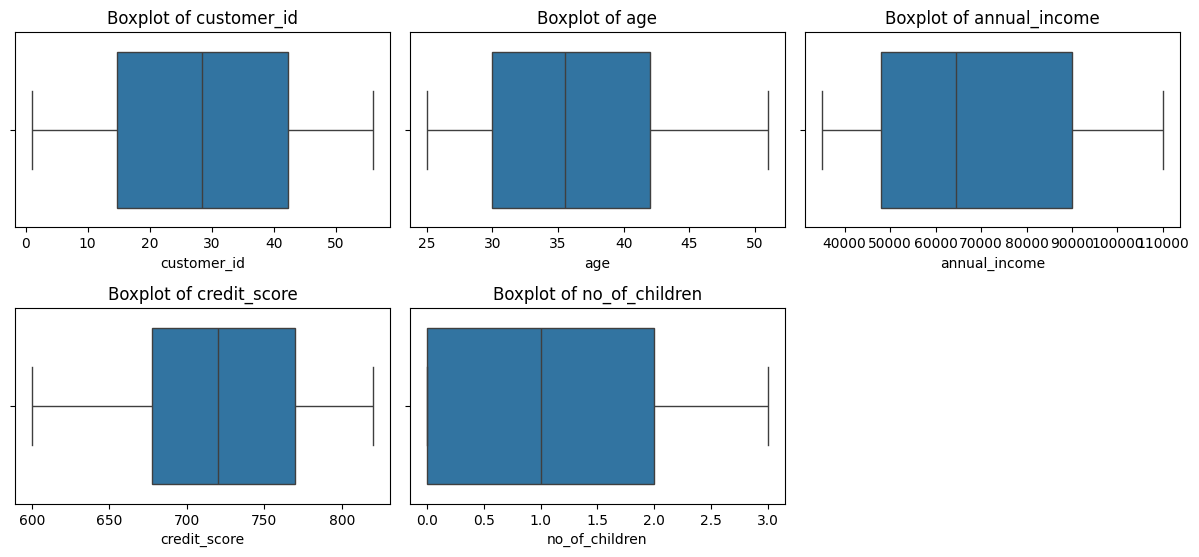

In [32]:
numerical_features = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i) # Adjust the layout based on the number of features
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

In [33]:
def detect_outliers_iqr(df):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers
outliers = detect_outliers_iqr(df)
for feature, outlier_data in outliers.items():
    print(f"\nOutliers in {feature}:")
    print(outlier_data)


Outliers in customer_id:
Empty DataFrame
Columns: [customer_id, age, gender, annual_income, credit_score, employed, marital_status, no_of_children, responded]
Index: []

Outliers in age:
Empty DataFrame
Columns: [customer_id, age, gender, annual_income, credit_score, employed, marital_status, no_of_children, responded]
Index: []

Outliers in annual_income:
Empty DataFrame
Columns: [customer_id, age, gender, annual_income, credit_score, employed, marital_status, no_of_children, responded]
Index: []

Outliers in credit_score:
Empty DataFrame
Columns: [customer_id, age, gender, annual_income, credit_score, employed, marital_status, no_of_children, responded]
Index: []

Outliers in no_of_children:
Empty DataFrame
Columns: [customer_id, age, gender, annual_income, credit_score, employed, marital_status, no_of_children, responded]
Index: []


In [34]:
numerical_features = df.select_dtypes(include=[np.number]).columns
categorical_features = df.select_dtypes(include=[object]).columns
print("\nNumerical Features:")
print(numerical_features)
print("\nCategorical Features:")
print(categorical_features)



Numerical Features:
Index(['customer_id', 'age', 'annual_income', 'credit_score',
       'no_of_children'],
      dtype='object')

Categorical Features:
Index(['gender', 'employed', 'marital_status', 'responded'], dtype='object')


In [35]:
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
for feature in categorical_features:
    df[feature] = df[feature].fillna(df[feature].mode()[0])
print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
customer_id       0
age               0
gender            0
annual_income     0
credit_score      0
employed          0
marital_status    0
no_of_children    0
responded         0
dtype: int64


In [36]:
df_cleaned = df.copy()
for column in df.select_dtypes(include=[np.number]).columns:
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
print("\nShape of Dataset After Removing Outliers: ", df_cleaned.shape)


Shape of Dataset After Removing Outliers:  (56, 9)
